# Model

In [33]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle

## Data Preprocessing

In [2]:
recs = pd.read_csv('data/pruned.csv')

In [3]:
recs.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,534380,0,0,2022-10-08,True,40.6,10531,22
1,42700,6,2,2019-10-19,False,5.9,185293,27
2,602960,0,0,2022-01-05,True,41.9,319249,58
3,976730,0,0,2021-11-25,False,21.1,747545,67
4,1091500,2,0,2022-10-30,True,18.1,2113544,127


In [4]:
USED_COLS = ['app_id', 'is_recommended', 'user_id']

recs = recs[USED_COLS]
recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [5]:
item_data = pd.read_csv('data/games.csv')
item_data.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


In [6]:
titles = item_data[['app_id', 'title']]

## Data Class

In [7]:
from RecData import RecData

In [8]:
class Metrics:
    def rmse(self, predictions):
        return math.sqrt(sum((prediction - true_rating)**2 for _, _, prediction, true_rating in predictions)/len(predictions))

In [9]:
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

In [10]:
train_data, test = rec_data.leave_k_out_split()

## Simple Model

In [11]:
def item_averages(M):
    # Division by 0 -> no data for item -> predict average of all items
    with np.errstate(invalid='ignore'):
        # Take item averages
        averages = (np.sum(M.toarray(), axis=0)/np.count_nonzero(M.toarray(), axis=0))

        # Fill na with averages over all items
        averages = np.nan_to_num(averages, nan=np.nanmean(averages))
    return averages

In [12]:
class AveragePredictor:
    """Simple model which always predicts the average value of an item."""
    def fit(self, M):
        self._averages = item_averages(M)
        
    def predict(self, pairs):
        """Parameters:
        pairs - user-item pairs to predict"""
        predictions = []
        for user, item in pairs:
            predictions.append((user, item, self._averages[item]))

        return predictions

In [13]:
predictor = AveragePredictor()
predictor.fit(train_data.get_matrix())

In [14]:
predictions = predictor.predict([(user, item) for user, item, _ in test])
predictions = [prediction + (test[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
metrics.rmse(predictions)

0.3714704647991523

## SVD

In [55]:
from scipy.sparse.linalg import norm as sparse_norm
from scipy.sparse import vstack
from collections import defaultdict
import time
import random

class SVDPredictor:
    """SVD for collaborative filtering"""
    def __init__(self, num_users, num_items, k=100, learning_rate=0.01, epochs=5, C=0.02, partial_batch_size=int(1e5), inv_transform=lambda x: x):
        self._num_users = num_users
        self._num_items = num_items
        self._inv_transform = inv_transform
        
        self._k = k
        self._learning_rate = learning_rate
        self._epochs = epochs
        self._C = C
        self._partial_batch_size = partial_batch_size
        
        self._user_features = np.random.normal(size=(self._num_users, self._k), scale=0.01)
        self._item_features = np.random.normal(size=(self._num_items, self._k), scale=0.01)
        
        self._M = None
        self._num_samples = None
        self._train_errors = None
        self._val_errors = None
    
    def fit(self, M, validation_set=None):
        self._M = M
        self._train_errors = []
        if validation_set:
            self._val_errors = []
        
        users, items = M.nonzero()
        self._num_samples = len(users)
        self._mask = (M != 0)
        
        for epoch in range(self._epochs):
            start_time = time.time()
            
            for i in random.sample(range(self._num_samples), k=self._num_samples):
                self._update_features(i, users, items)                
            
            print("Epoch", epoch, end="/")

            self._show_error()
            
            if validation_set:
                predictions = self.predict([(user, item) for user, item, _ in validation_set])
                predictions = [prediction + (validation_set[i][2],) for i, prediction in enumerate(predictions)]
                metrics = Metrics()
                val_error = metrics.rmse(predictions)
                self._val_errors.append(val_error)
                print("Validation error:", val_error, end="/")
                
            print("Time:", round(time.time() - start_time, 2), "seconds")
            
    def partial_fit(self, new_sample):
        users, items = self._M.nonzero()
        self._M = vstack([self._M, new_sample])
        total_users, total_items = self._M.nonzero()
        
        self._mask = (self._M != 0)
        
        num_samples = len(users)
        new_sample_index = self._num_users
        self._num_users += 1
        
        self._user_features = np.concatenate([self._user_features, np.random.normal(size=(1, self._k), scale=0.01)], axis=0)
                                                                               
        indices_of_new = [new_i for new_i in range(len(users), len(total_users))]
                                              
        for epoch in range(self._epochs):
            start_time = time.time()
            # Choose a smaller subset of total samples already fitted
            fitted_subset = random.sample(range(num_samples), k=self._partial_batch_size)    
            
            # Ensure that new indices are always used
            possible_indices = fitted_subset + indices_of_new
            
            # Perform update for each sample
            for i in random.sample(possible_indices , k=len(possible_indices)):
                self._update_features(i, total_users, total_items)
            
            
            print("Epoch", epoch, end="/")
            self._show_error()
            print("Time:", round(time.time() - start_time, 2), "seconds")
            
        
    def top_n(self, user, n=10):
        """Return the top n recommendations for given user.
        
        Parameters:
            user (int) - The index of the user
            n (int) - The number of recommendations to give
            
        Preconditions:
            n > 0"""
        if self._M is None:
            raise RuntimeError("Please ensure to call fit before generating top n")
        users, items = self._M[[user], :].nonzero()
        
        users_rated = []
        for i in range(len(users)):
            users_rated.append(items[i])
        
        top = []
        for item in range(self._num_items):
            # Do not add items for which rating already exists
            if item in users_rated:
                continue
                
            predicted_rating = self._user_features[user, :] @ np.transpose(self._item_features)[:, item]
            
            top.append((predicted_rating, item))
            top.sort(key=lambda x: x[0], reverse=True)
            top = top[:min(n, len(top))]
        
        return top
        
    def predict(self, pairs):
        """Returns a list of predictions of the form (user, item, prediction) for each (user, item) pair in pairs.
        
        Parameters:
            pairs (list) - List of (user, item) tuples.
            
        Returns:
            List of (user, item, prediction) tuples."""
        predictions = []
        for user, item in pairs:
            prediction = self._inv_transform(self._user_features[user, :] @ np.transpose(self._item_features)[:, item]) 
            predictions.append((user, item, prediction))
        
        return predictions
    
    def get_train_errors(self):
        """Return the training errors stored while training. Returns none if model has not been fit."""
        return self._train_errors
    
    def get_val_errors(self):
        """Return the validation errors stored while training. Returns none if model has not been fit."""
        return self._val_errors
    
    def _update_features(self, i, users, items):
        user = users[i]
        item = items[i]                  

        diff = self._learning_rate*(self._M[user, item] - self._user_features[user, :] @ np.transpose(self._item_features[item, :]))

        # Compute user features update
        new_user_features = self._user_features[user, :] + diff*self._item_features[item, :]

        # Compute item features update
        self._item_features[item, :] += diff*self._user_features[user, :]

        self._user_features[user, :] = new_user_features
        
    def _show_error(self):
        big_diff = self._M - self._user_features @ np.transpose(self._item_features)
        
        # Mask to ignore error from missing reviews
        big_diff = self._mask.multiply(big_diff)
        error = sparse_norm(big_diff) / np.sqrt(self._num_samples)
        self._train_errors.append(error)
        print("Training error:", error, end="/")


Below is testing partial fit.

In [ ]:
EPOCHS = 5

# Fit and predict with svd
svd_predictor = SVDPredictor(train_data.get_num_users() - 1, train_data.get_num_items(), k=10, epochs=EPOCHS, learning_rate=0.01, C=0, partial_batch_size=int(0))
svd_predictor.fit(train_data.get_matrix()[:-1, :])

svd_predictor.partial_fit(train_data.get_matrix()[[-1], :])

Below is predicting the top n and comparing with the true top n

In [26]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0] - 1)
print(top_n)
print([train_data.index_to_title(index) for _, index in top_n])

[(0.9458516997051617, 629), (0.9407295487903767, 1638), (0.9388828183440496, 134), (0.9348996575298925, 227), (0.9326027319914163, 358), (0.9314203058130033, 11), (0.931231228636118, 814), (0.927975039815232, 2117), (0.926124038327349, 1621), (0.9256785429420407, 1471)]
['Factorio', 'ULTRAKILL', 'Terraria', 'Kenshi', 'RimWorld', 'Portal 2', 'Half-Life: Alyx', 'Vampire Survivors', 'Gunfire Reborn', 'Inscryption']


In [16]:
true_top = rec_data.top_n(train_data.get_matrix().shape[0] - 1, 5)
print([rec_data.index_to_title(index) for _, index in true_top])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[11, 147, 182, 272, 332, 353, 510, 629, 822, 911, 1111, 1154, 1555, 1569, 1677, 1717, 1998, 2095, 2149]
['Portal 2', 'Crusader Kings II', 'The Binding of Isaac: Rebirth', 'The Witcher® 3: Wild Hunt', 'Hollow Knight']


Below is testings a fit on all data

Epoch 0/Training error: 1.7476429161484335/Validation error: 1.767134029872862/Time: 35.45 seconds
Epoch 1/Training error: 0.6590703017034694/Validation error: 0.6666384585091332/Time: 35.15 seconds
Epoch 2/Training error: 0.4650512324419057/Validation error: 0.4735831905891788/Time: 35.15 seconds
Epoch 3/Training error: 0.40409046366861723/Validation error: 0.41700902541444373/Time: 35.21 seconds
Epoch 4/Training error: 0.3751579285151075/Validation error: 0.391566956239983/Time: 35.31 seconds
Epoch 5/Training error: 0.3568754197270399/Validation error: 0.3785644776416417/Time: 35.07 seconds
Epoch 6/Training error: 0.34236151133160264/Validation error: 0.37030988869702325/Time: 35.39 seconds
Epoch 7/Training error: 0.3290632558183386/Validation error: 0.3643111921624675/Time: 35.26 seconds
Epoch 8/Training error: 0.31593508515207985/Validation error: 0.35995428518327727/Time: 34.98 seconds
Epoch 9/Training error: 0.30292460011561273/Validation error: 0.3568177962682625/Time: 35.41 sec

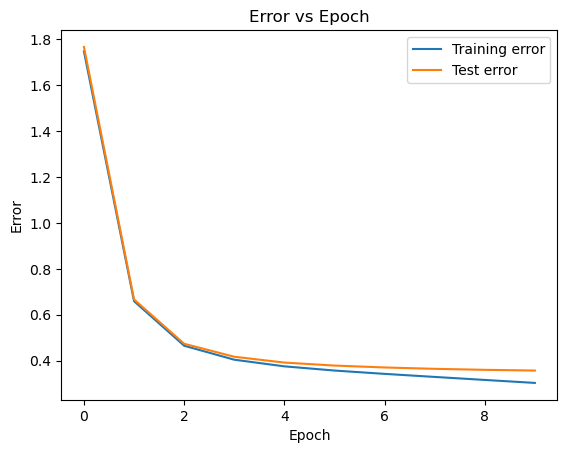

Test rmse 0.3568177962682625
[(2.1227740149114394, 384), (2.1219051285755812, 158), (2.119672746679292, 456), (2.1182598341787884, 153), (2.116010833117139, 544), (2.112057316326325, 1771), (2.1117884499413035, 1160), (2.1093081216725684, 679), (2.1081342103326515, 761), (2.1041262272491927, 1901)]
['Hexcells Infinite', 'Gunpoint', 'Choice of Robots', 'Infested Planet', 'Aviary Attorney', 'Against the Storm', 'Cosmoteer: Starship Architect & Commander', 'Parkitect', 'Glass Masquerade', 'Symphony of War: The Nephilim Saga']


In [67]:
EPOCHS = 10
MODEL_DIR = 'saved_models/save1.pkl'

# Fit and predict with svd
svd_predictor = SVDPredictor(train_data.get_num_users(), train_data.get_num_items(), k=1000, epochs=EPOCHS, learning_rate=0.01, C=0)
svd_predictor.fit(train_data.get_matrix(), validation_set=test)

# Ensure file exists
file = open(MODEL_DIR, 'a')
file.close()

# TODO CANNOT PICKLE LAMBDA
# print("Saving model...")
# with open(MODEL_DIR, 'wb') as file:
#     pickle.dump([svd_predictor, rec_data, train_data, test], file)
# print("Done saving model.")


# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(EPOCHS), errors, label='Training error')
plt.plot(range(EPOCHS), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict([(user, item) for user, item, _ in test])
predictions = [prediction + (test[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
print("Test rmse", metrics.rmse(predictions))

# Test top-n list
top_n = svd_predictor.top_n(0)
print(top_n)
print([train_data.index_to_title(index) for _, index in top_n])

In [25]:
true_top = rec_data.top_n(0)
print([rec_data.index_to_title(index) for _, index in true_top])

['Grand Theft Auto IV: The Complete Edition', 'Fallout: New Vegas', 'Dying Light', '7 Days to Die', 'American Truck Simulator', 'RimWorld', 'DARK SOULS™ II: Scholar of the First Sin', 'Dead Island Definitive Edition', 'DRAGON BALL XENOVERSE 2', 'Satisfactory']


Testing loading the model below

In [64]:
rec_data.search_title('aviary')

[('aviary attorney', 544)]

In [68]:
prefs = rec_data.create_prefs([(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (384, 0), (544, 0)])    

In [69]:
svd_predictor.partial_fit(prefs)
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0])
print([train_data.index_to_title(index) for _, index in top_n])

Epoch 0/Training error: 0.3030968916919741/Time: 4.48 seconds
Epoch 1/Training error: 0.30298895836276807/Time: 4.57 seconds
Epoch 2/Training error: 0.30253151683588886/Time: 4.6 seconds
Epoch 3/Training error: 0.3020875642130986/Time: 4.62 seconds
Epoch 4/Training error: 0.30144656840852363/Time: 4.66 seconds
Epoch 5/Training error: 0.30076816975843557/Time: 4.65 seconds
Epoch 6/Training error: 0.30002634434214664/Time: 4.53 seconds
Epoch 7/Training error: 0.2991396458154676/Time: 4.56 seconds
Epoch 8/Training error: 0.2983969131072029/Time: 4.6 seconds
Epoch 9/Training error: 0.2975937080224897/Time: 4.65 seconds
['A Hat in Time', 'West of Loathing', 'Wallpaper Engine', 'Cruelty Squad', 'Baba Is You', 'POSTAL 2', 'One Finger Death Punch 2', 'DUSK', 'Parkitect', 'Borderlands 2']


In [ ]:
MODEL_DIR = 'saved_models/save1.pkl'

saved = None
with open(MODEL_DIR, 'rb') as file:
    saved = pickle.load(file)
    
svd, rec_data, train_data, test = saved

